## Data Clean up
Authors: Abzer Kelminal (abzer.shah@uni-tuebingen.de) <br>
Edited by:  <br>
Input file format: .csv files or .txt files <br>
Outputs: .csv files  <br>
Dependencies: ggplot2, dplyr

In [121]:
#installing and calling the necessary packages:
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ecodist")) install.packages("ecodist")
if (!require("vegan")) install.packages("vegan")

Loading required package: ecodist
Warning message:
"package 'ecodist' was built under R version 3.6.3"

In [150]:
if (!require("svglite")) install.packages("svglite")

Loading required package: svglite
Warning message:
"package 'svglite' was built under R version 3.6.3"

## Reading the input data using URL (from Github):

In [ ]:
## Non-gap filled
nft_url <- 'https://raw.githubusercontent.com/madeleineernst/Metabolomics_SummerSchool_2022/main/data/MZmine/Xenobiotic_Metabolism_ChemProp2_NonGapFilled_QuantTable.csv'
## Gap filled
ft_url <- 'https://raw.githubusercontent.com/madeleineernst/Metabolomics_SummerSchool_2022/main/data/MZmine/Xenobiotic_Metabolism_ChemProp2_GapFilled_QuantTable.csv'
md_url <- 'https://raw.githubusercontent.com/madeleineernst/Metabolomics_SummerSchool_2022/main/data/Xenobiotic_Metabolism_metadata.txt'

In [ ]:
nft <- read.csv(nft_url, header = T, check.names = F)
ft <- read.csv(ft_url, header = T, check.names = F)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

## Setting a local working directory and creating an automatic result directory:

In [ ]:
# setting the current directory as the working directory
Directory <- normalizePath(readline("Enter the path of the folder with input files: "),"/",mustWork=FALSE)
setwd(Directory)

In [ ]:
getwd() #to get the working directory 

In [ ]:
# Getting all the files in the folder
dirs <- dir(path=paste(getwd(), sep=""), full.names=TRUE, recursive=TRUE)
folders <- unique(dirname(dirs))
files <- list.files(folders, full.names=TRUE)
files_1 <- basename((files))
files_2 <- dirname((files))
# Creating a Result folder
dir.create(path=paste(files_2[[1]], "_Results", sep=""), showWarnings = TRUE)
fName <-paste(files_2[[1]], "_Results", sep="")

print(files_1)

**<font color='red'> In the following line, enter the required file ID numbers separated by commas. For example as: 1,2,3 </font>**

In [ ]:
input <- as.double(unlist(strsplit(readline("Specify the file index of gapfilled & non-gapfilled feature-file, metadata:"), split=",")))

#Gets the extension of each file. Ex:csv
pattern <- c()
for (i in files_1){
  sep_file <- substr(i, nchar(i)-2,nchar(i))
  pattern <- rbind(pattern,sep_file)
}
#pattern

ft <- read.csv(files_1[input[1]],sep = ifelse(pattern[input[1]]!="csv","\t",","), header=TRUE,check.names = FALSE) # By applying 'row.names = 1', the 1st column 'ID' becomes the row names
nft<- read.csv(files_1[input[2]],sep=ifelse(pattern[input[2]]!="csv","\t",","), header = TRUE,check.names = FALSE)
md <-read.csv(files_1[input[3]], sep = ifelse(pattern[input[3]]!="csv","\t",","), header=TRUE,check.names = FALSE)

Lets check if the data has been read correclty!!

In [ ]:
head(ft)
dim(ft)

In [ ]:
head(nft)
dim(nft)

In [ ]:
head(md)
dim(md)

Trying to bring the feature table and metadata in the correct format:

In [ ]:
#Removing Peak area extensions
colnames(ft) <- gsub(' Peak area','',colnames(ft))
colnames(nft) <- gsub(' Peak area','',colnames(nft))
md$filename<- gsub(' Peak area','',md$filename)

#Removing if any NA columns present in the md file
ft <- ft[,colSums(is.na(ft))<nrow(ft)]
nft <- nft[,colSums(is.na(nft))<nrow(nft)]
md <- md[,colSums(is.na(md))<nrow(md)]

#Changing the row names of the files
rownames(md) <- md$filename
md <- md[,-1]
rownames(ft) <- paste(ft$'row ID',round(ft$'row m/z',digits = 3),round(ft$'row retention time',digits = 3), sep = '_')
rownames(nft) <- paste(nft$'row ID',round(nft$'row m/z',digits = 3),round(nft$'row retention time',digits = 3), sep = '_')

#Picking only the files with column names containing 'mzML'
ft <- ft[,grep('mzML',colnames(ft))]
nft <- nft[,grep('mzML',colnames(nft))]

# Converting replicate attributes into factors (categorical data)
md$ATTRIBUTE_replicates <- as.factor(md$ATTRIBUTE_replicates)

Lets check the files once again!!

In [ ]:
head(nft)
dim(nft)

In [ ]:
head(ft)
dim(ft)

In [ ]:
head(md)
dim(md)

### Creating a function named FrequencyPlot:  
The below function takes in the two input datatables: for example, gapfilled and non-gapfilled, calculates the frequency distribution of the data in the order of 10 and produces a grouped barplot showing the distribution as output. The frequency plot shows where the features are present in higher number.

In [ ]:
#'Global' settings for plot size in the output cell
#options(repr.plot.width=10, repr.plot.height=8,res=600) #For google collab
options(repr.plot.width=5, repr.plot.height=3) #For Jupyter Notebook

In [ ]:
FrequencyPlot <- function(x1,x2){
  
   #creating bins from -1 to 10^10 using sequence function seq()
    bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) 
    
    #cut function cuts the give table into its appropriate bins
    scores_x1 <- cut(as.matrix(x1),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10')) 
    
    #transform function convert the tables into a column format: easy for visualization 
    Table_x1<-transform(table(scores_x1)) #contains 2 columns: "scores_x1", "Freq"
    
    #Repeating the same steps for x2
    scores_x2 <- cut(as.matrix(x2),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10'))
    Table_x2<-transform(table(scores_x2))
  
    #Getting the names of x1 and x2
    arg1 <- deparse(substitute(x1))
    arg2 <-deparse(substitute(x2))
    
    #Creating a data frame for plotting
    data_plot <- as.data.frame(c(Table_x1$Freq,Table_x2$Freq)) #Concatenating the frequency info of both tables rowwise
    colnames(data_plot) <- "Freq" #naming the 1st column as 'Freq'
    data_plot$Condition <- c(rep(arg1,12),rep(arg2,12)) #adding a 2nd column 'Condition', which just repeats the name of x1 and x2 accordingly
    data_plot$Range_bins <- rep(Table_x1$scores_x1,2) #Adding 3rd column 'Range Bins'
    data_plot$Log_Freq <- log(data_plot$Freq+1) #Log scaling the frequency values
    
    ## GGPLOT2
    BarPlot <- ggplot(data_plot, aes(Range_bins, Log_Freq, fill = Condition)) + 
    geom_bar(stat="identity", position = "dodge", width=0.4) + 
    scale_fill_brewer(palette = "Set1") +
    ggtitle(label="Frequency plot") +
    xlab("Range") + ylab("(Log)Frequency") + labs(fill = "Data Type") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +   # setting the angle for the x label
    theme(axis.text.y = element_text(angle = 45, vjust = 0.5, hjust=1)) +   # setting the angle for the y label
    theme(plot.title = element_text(hjust = 0.5)) # centering the plot title
  
    print(BarPlot)
}  

**About the experiment:**
- Bacteria (B.subtilis) was treated with a pool of antibiotics (Sulfamethoxazole, sulfadimethoxine, cyproconazole) including a herbicide Asulam, taken at a concentration lower than their MIC (minimum inhibitory concentration).
- The samples were collected at different timepoints, the compounds were extracted (with 50% EtOAc) and measured using LC-MS/MS.
- The goal of the experiment was to look for any potential biotransformation. eg: Drug or xenobiotic metabolism

## Splitting the data into Control and Samples using Metadata:

In [ ]:
head(md)
print(matrix(data=colnames(md),nrow=length(colnames(md))))

#These lines are not needed in R console, but in Jupyter Notebook to get the previous print statement working
flush.console()  
Sys.sleep(0.2)

Condition <- as.double(unlist(readline("Enter the index of the attribute to split sample and control:")))

flush.console()  
Sys.sleep(0.2)

Levels_Cdtn <- levels(as.factor(md[,Condition[1]]))
print(matrix(Levels_Cdtn,length(Levels_Cdtn)))

flush.console()  
Sys.sleep(0.2)
    
#Among the shown levels of an attribute, select the ones to keep
Ctrl_id <- as.double(unlist(readline("Enter the index of your BLANK:")))
paste0('You chosen blank is:',Levels_Cdtn[Ctrl_id])

#Splitting the data into control and samples based on the metadata
md_Ctrl <- md[(md[,Condition] == Levels_Cdtn[Ctrl_id]),]
Ctrl <- input_data[,which(colnames(input_data)%in%rownames(md_Ctrl))] 
md_Samples <- md[(md[,Condition] != Levels_Cdtn[Ctrl_id]),]
Samples <- input_data[,which(colnames(input_data)%in%rownames(md_Samples))] 

In [ ]:
head(Ctrl)
dim(Ctrl)

In [ ]:
head(Samples)
dim(Samples)

In [ ]:
FrequencyPlot(Samples,Ctrl)

## Blank Removal:

(Note: In LC-MS/MS, we use solvents also called as Blanks which are usually injected time-to-time to prevent carryover of the sample) </br>

For the Blank removal step, we need to split the data as control blanks and samples. </br>

**The blanks we are referring to here, is the control blanks in the experiment and not the LC-MS/MS blanks.**
- The control blanks here is the sample without treatment. 
- Samples are biological replicates with treatment and we have two sets of data: B.sub and E.coli. </br>

In general, having multiple control blanks helps us to compare any variation in the data. Comparing control to the sample helps us to identify the background features that contribute to any technical variation. A common filtering method is to use a cutoff to remove features that are not present sufficient enough in our biological samples.

1. We find an average for all the feature intensities in your control set and sample set.
Therefore, for n no.of features in a control or sample set, we get n no.of averaged features.
2. Next, we get a ratio of this average_control vs average_sample. This ratio Control/sample tells us how much of that particular feature of a sample gets its contribution from control. If it is more than 30% (or Cutoff as 0.3), we consider the feature as noise.
3. The resultant information (if ratio > Cutoff or not) is stored in a bin
4. We count the no.of features in the bin that satisfies the condition ratio > cutoff, and consider those features as 'noise or background features' and remove them.

For a dataset containing several batches, the filtering steps are performed batch-wise.

<font color='red'>Note: The Cutoff value chosen for getting the files in the folder **Preprocessing Jupyter Output files-Data CleanUp** in the github: 0.9 </font>

In [ ]:
if(readline('Do you want to perform Blank Removal- Y/N:')=='Y'){
    
    #When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
    Cutoff <- as.numeric(readline('Enter Cutoff value between 0.1 & 1:')) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3
    
    #Getting mean for every feature in Ctrl and Samples
    Avg_ctrl <- rowMeans(Ctrl, na.rm= FALSE, dims = 1) # set na.rm = FALSE to check if there are NA values. When set as TRUE, NA values are changed to 0
    Avg_samples <- rowMeans(Samples, na.rm= FALSE, dims = 1)
    
    #Getting the ratio of Ctrl vs Sample
    Ratio_Ctrl_Sample <- (Avg_ctrl+1)/(Avg_samples+1)
    
    # Creating a bin with 1s when the ratio>Cutoff, else put 0s
    Blank_removal <- Samples
    Blank_removal$Bg_bin <- ifelse(Ratio_Ctrl_Sample > Cutoff, 1, 0 )

    # Checking if there are any NA values present. Having NA values in the 4 variables will affect the final dataset to be created
    temp_NA_Count <-cbind(Avg_ctrl ,Avg_samples,Ratio_Ctrl_Sample,Bg_bin)
    
    print('No of NA values in the following columns:')
    print(colSums(is.na(temp_NA_Count)))

     #Calculating the number of background features and features present
    print(paste("No.of Background or noise features:",sum(Bg_bin ==1,na.rm = TRUE)))
    print(paste("No.of features after excluding noise:",(nrow(Samples) - sum(Bg_bin ==1,na.rm = TRUE)))) 

    Blank_removal <- Blank_removal %>% filter(Bg_bin == 0)
    Blank_removal <- as.matrix(Blank_removal[,-ncol(Blank_removal)])
}

## Imputation: 

For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. 
In order to have a better dataset, we cannot simply discard those rows or columns with missing values as we will lose a chunk of our valuable data.
Instead we can try imputing those missing values. Imputation involves replacing the missing values in the data with a meaningful, reasonable guess. There are several methods, such as:  
1) Mean imputation (replacing the missing values in a column with the mean or average of the column)  
2) Replacing it with the most frequent value  
3) Several other machine learning imputation methods such as k-nearest neighbors algorithm(k-NN), Hidden Markov Model(HMM)

One such method, we are going to use is: **to replace the zeros from the gapfilled quant table with the non-gap filled table** we get from MZmine. In order to do that, we can visualize our data distribution using the frequenct plot

In [118]:
GapFilled <-Blank_removal
NotGapFilled <- nft

Do you want to perform Imputation with minimum value of NonGapFilled table? - Y/N:Y
[1] "The minimum value greater than 0 for GapFilled:123"
[1] "The minimum value greater than 0 for NotGapFilled:3766"


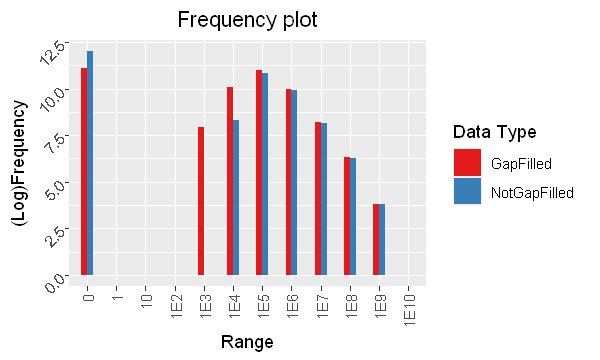

In [119]:
if(readline('Do you want to perform Imputation with minimum value of NonGapFilled table? - Y/N:')=='Y'){
    
    plot<- FrequencyPlot(GapFilled,NotGapFilled)
    
    Arg1 = plot$data$Condition[1]
    Arg2 = plot$data$Condition[13]
    
    # accessing the datatable of plot and subsetting with the condition: Eliminating the Range (or bin) 0 and Ranges with zero frequencies 
    plotData_New <- subset(plot$data,plot$data$Freq!=0 & plot$data$Range_bins !=0) 
    
    #getting the first appearing value of this new plot datatable
    First_val_temp <- aggregate(plotData_New$Freq, by=list(plotData_New$Condition), FUN=first) 
    
    # Subsetting the rows in the plotData_New that has the first appearing values
    First_val <- plotData_New[plotData_New$Freq %in% c(First_val_temp$x[1],First_val_temp$x[2]),]
  
    # getting the 2nd minimum value of non-gap filled data. (The first minimum value in the data table is usually zero)
    RawLOD <- round(min(NotGapFilled[NotGapFilled!=min(NotGapFilled)]))
    print(paste0("The minimum value greater than 0 for ",Arg1,":", round(min(GapFilled[GapFilled!=min(GapFilled)]))))
    print(paste0("The minimum value greater than 0 for ",Arg2,":", RawLOD))
    
    Imputed <- GapFilled
    Imputed[Imputed<RawLOD] <- RawLOD # Replacing values<RawLOD with RawLOD
} else return(GapFilled)

In [ ]:
write.csv(Imputed, file=paste0('Quant_Table_filled_with_MinValue_',RawLOD,'.csv'),row.names =FALSE) 

In [99]:
head(Imputed)
dim(Imputed)

,t2_BS_C.mzML,t0_BS_C.mzML,t1_BS_C.mzML,t5_BS_C.mzML,t3_BS_3.mzML,t2_BS_2.mzML,t3_BS_C.mzML,t2_BS_1.mzML,t3_BS_2.mzML,t1_BS_1.mzML,...,t5_BS_3.mzML,t6_BS_2.mzML,t5_BS_1.mzML,t6_BS_3.mzML,t0_BS_1.mzML,t9_BS_1.mzML,t5_BS_2.mzML,t8_BS_3.mzML,t9_BS_3.mzML,t9_BS_2.mzML
46_284.049_0.292,28967.65,6016.644,19891.79,137709.25,38654.650,123643.766,48592.70,87621.97,15638.634,43170.520,...,140709.11,57526.60,30458.35,3766.00,35278.086,69360.08,46725.547,69138.67,41619.816,158943.36
95_245.095_0.52,3766.00,3766.000,3766.00,43263.97,68092.710,54846.290,51597.93,40212.03,68410.980,74559.234,...,19731.48,63450.43,15515.95,73982.30,173294.600,34425.60,45211.176,30443.56,34075.530,51332.15
99_157.097_0.52,3766.00,3766.000,3766.00,4953.36,8625.011,4815.979,4152.35,3766.00,7641.581,6916.565,...,3766.00,14335.19,3766.00,16845.83,8836.821,15117.90,6946.169,10768.89,14589.145,31121.90
106_166.103_0.532,3766.00,3766.000,3766.00,3766.00,3766.000,3766.000,3766.00,3766.00,3766.000,3766.000,...,3766.00,3766.00,3766.00,3766.00,3766.000,3766.00,3766.000,3766.00,7789.463,11774.10
107_160.076_0.522,3766.00,3766.000,3766.00,354050.30,427649.620,312332.620,313545.00,209269.45,593663.900,401620.970,...,242058.36,954094.75,213120.95,814353.56,404429.660,931383.94,427234.220,666837.30,1050392.200,1309049.90
111_169.097_0.525,3766.00,4054.369,3766.00,637458.60,706535.700,609720.940,615655.20,468750.70,706034.300,665166.500,...,436133.40,893395.44,378563.44,886614.50,800889.440,890976.94,687120.800,804205.44,986138.440,1347099.20


[1] 4496   40

## Imputation with a Cutoff LOD:
Previously we have replaced the zeros in our Blank removed feature table(gapfilled) with the minimum value in nft(non gapfilled). Ex: 3766.<br>

Instead, we can also only use  Blank removed feature table and see the frquency distribution of its features with the frequency plot. The frequency plot shows where the features are present in higher number.

For ex: If until range 10-100, (shown in the figure as 1E2) there are no or very less features, we want to exclude until that range and consider from range (100-1000), or, in other words, '1E3' or '1000' as Cutoff_LOD. This value will be used to replace the zeros in the data table.

The following step asks if the imputation was already performed, if so, it takes that value as the Cutoff_LOD, else, we get to specify our Cutoff_LOD based on the frequency plot.

In [102]:
Cutoff_LOD <-ifelse(readline("Was Imputation step already performed? Y/N :")=="Y",RawLOD,as.numeric(readline("Enter your Cutoff LOD here:")))  #Enter the LOD value as seen in the frequency plot
Imputed<- Blank_removal
Imputed[Imputed_LOD <Cutoff_LOD] <- Cutoff_LOD

Was Imputation step already performed? Y/N :N
Enter your Cutoff LOD here:1000


In [ ]:
write.csv(Imputed,file.path(fName, paste0('Processed_QuantTable_filled_with_',Cutoff_LOD,'_CutOff_Used_',Cutoff,'_Bsub','.csv')),row.names =TRUE)

In [ ]:
#removing all the rows with only cutoff values:
Imputed<-Imputed[rowMeans(Imputed)!= Cutoff_LOD,]  

## Normalization:
The following code performs sample-centric (column-wise) normalisation:

In [123]:
if (readline("Do you want to perform Normalization: Y/N:") == 'Y'){
    
    #Getting column-wise sums of the input-data
    sample_sum <- colSums(Imputed, na.rm= TRUE, dims = 1)
    
    #Dividing each element of a particular column with its column sum
    Normalized_data <- c()
    for (i in 1:ncol(Imputed)){
        x <- Imputed[,i] / sample_sum[i]
        Normalized_data <- cbind(Normalized_data, x)
    }
    colnames(Normalized_data) <- names(sample_sum)
    
} else return(Imputed)
  
print(paste('No.of NA values in Normalized data:',sum(is.na(Normalized_data)== TRUE)))

Do you want to perform Normalization: Y/N:Y
[1] "No.of NA values in Normalized data: 0"


In [ ]:
write.csv(Normalized_data,file.path(fName,'Normalised_Quant_table.csv'),row.names =TRUE) 

## Principal Coordinate analysis:

In [124]:
#Making sure the metadata rownames are identical to that of filenames in our featuretable in order to perform multivariate statistics
md_Stats <- md[which(rownames(md)%in%colnames(Normalized_data)),]
md_Stats <- md_Stats[match(colnames(Normalized_data),rownames(md_Stats)),]
identical(colnames(Normalized_data),rownames(md_Stats))

#Checking the data sparsity:
sum(Normalized_data == 0)/(dim(Normalized_data)[1]*dim(Normalized_data)[2])

[1] TRUE

[1] 0

In [128]:
dist_matrix <- bcdist(t(Normalized_data)) # transposed in order to compute the distance between the columns of a data matrix
pcoa<- cmdscale(dist_matrix, eig = TRUE, x.ret=TRUE)
pcoa.var.per <-round(pcoa$eig/sum(pcoa$eig)*100,1)
pcoa.values <- pcoa$points

In [145]:
#PCoA calculation
print(matrix(data=colnames(md_Stats),nrow=length(colnames(md_Stats))))
at_int <- readline('Enter the index of interested attribute for PCoA:')
pcoa.data <- data.frame(md_Stats[,as.double(at_int)],
                        X=pcoa.values[,1],
                        Y=pcoa.values[,2])

     [,1]                      
[1,] "ATTRIBUTE_species"       
[2,] "ATTRIBUTE_With_Treatment"
[3,] "ATTRIBUTE_timepoint"     
[4,] "ATTRIBUTE_hours"         
[5,] "ATTRIBUTE_mins"          
[6,] "ATTRIBUTE_replicates"    
Enter the index of interested attribute for PCoA:3


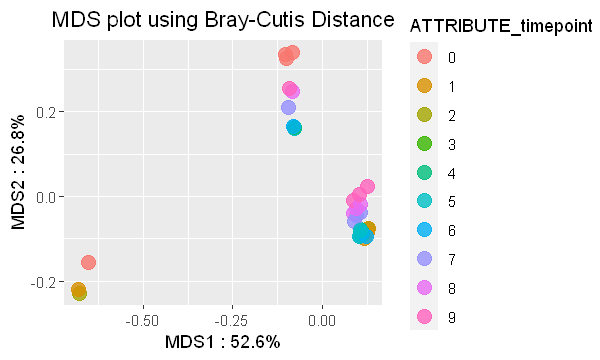

In [146]:
#PCoA plot:
PCoA_plot <- ggplot(pcoa.data, aes(x=X, y=Y, col= as.factor(md_Stats[,as.double(at_int)]))) + 
  geom_point(size=4,alpha=0.8)  +
  ggtitle(label="MDS plot using Bray-Cutis Distance") +
  xlab(paste0("MDS1 : ",pcoa.var.per[1],"%",sep="")) + 
  ylab(paste0("MDS2 : ",pcoa.var.per[2],"%",sep="")) + 
  labs(color = colnames(md_Stats)[as.double(at_int)]) + 
  theme(plot.title = element_text(hjust = 0.5)) 
PCoA_plot

## Permutational multivariate analysis of variance (PERMANOVA):

In [147]:
adonres <- adonis2(dist_matrix  ~ md_Stats[,as.double(at_int)])
rownames(adonres)[1] <- colnames(md_Stats)[as.double(at_int)]
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
ATTRIBUTE_timepoint,1,0.4270834,0.1293081,5.643451,0.001
Residual,38,2.8757523,0.8706919,NA,NA
Total,39,3.3028357,1.0000000,NA,NA


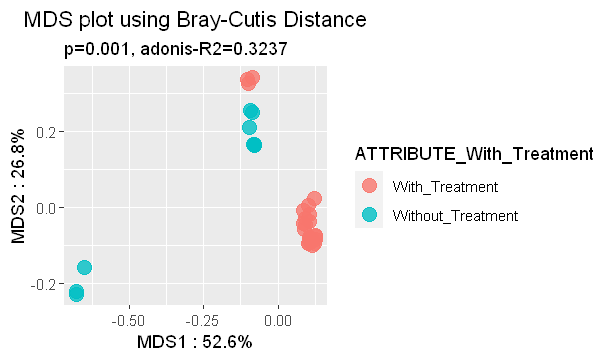

In [144]:
PCoA_plot + labs(subtitle = paste0("p=",round(adonres$'Pr(>F)'[1],4),', ' ,"adonis-R2=",round(adonres$'R2'[1],4)))

In [152]:
ggsave(PCoA_plot,path=fName,filename="MDS_plot.svg", width = 10, height = 8)